In [25]:
import pickle
import pandas as pd
import numpy as np
from os.path import abspath, join

%matplotlib inline

In [4]:
# save data as pickle

TRAIN_DATA = "../data/raw/underexpore_train"
TEST_DATA = "../data/raw/underexpore_test"
OUTPUT_DIR = "../data/out"

if 1 == 0:
    with open(join(OUTPUT_DIR, "data.pkl"), "wb") as file:
        pickle.dump(df_data_mapping, file)
else:
    with open(join(OUTPUT_DIR, "data.pkl"), "rb") as file:
        df_data_mapping = pickle.load(file)

## vec feature

In [5]:
df_data_mapping["item_feat"]

,item_id,txt_vec,img_vec
0,42844,"4.514945030212402, -2.3837196826934814, 0.5004...","-2.8722801208496094, 1.4587551355361938, 2.579..."
1,67898,"-2.0029051303863525, -0.9298805594444275, 0.79...","-0.07052088528871536, -1.4393335580825806, 0.7..."
2,66446,"4.221673011779785, -1.4971394538879395, 1.1335...","-5.18036413192749, -0.38824713230133057, -0.03..."
3,63651,"2.6579699516296387, -0.941863477230072, 1.1215...","-1.077273964881897, 2.8394529819488525, 1.1834..."
4,46824,"3.192194938659668, -1.9366759061813354, 1.1999...","-3.2601945400238037, 0.49889034032821655, 2.58..."
...,...,...,...
108911,79253,"2.1436519622802734, -1.5911839008331299, -0.28...","-3.6203484535217285, -0.13181450963020325, -2...."
108912,109138,"0.8901849985122681, 0.04266921430826187, 2.842...","1.9070663452148438, -1.0915212631225586, -1.43..."
108913,62184,"1.4589283466339111, -0.6386770606040955, -0.95...","-1.8863677978515625, 0.2406638264656067, -0.41..."
108914,42748,"3.3835203647613525, -1.6698633432388306, 1.264...","-2.6400721073150635, 1.0721999406814575, 1.514..."


In [6]:
df_data_mapping.keys()

dict_keys(['item_feat', 'user_feat', 'train_click', 'test_click', 'test_qtime'])

In [13]:
df_data_mapping["train_click"].query("user_id == '4965'").sort_values("time", ascending=True)

,user_id,item_id,time,Phase
24359,4965,33354,0.983758,0
98049,4965,43218,0.983763,0
0,4965,18,0.983763,0
84794,4965,66446,0.983777,0
205362,4965,3598,0.983787,0
...,...,...,...,...
186411,4965,103542,0.984264,6
55889,4965,116643,0.984264,6
262979,4965,117340,0.984264,6
130891,4965,113031,0.984276,6


In [79]:
# mean record counts
df_train_click = (
    df_data_mapping["train_click"].sort_values(["user_id", "time"], ascending=[True, True])
    .groupby("user_id")
    .apply(lambda x: x.assign(t_diff = x["time"].diff()))
).reset_index(drop=True)

In [81]:
s_time_diff = df_train_click["t_diff"]

In [89]:
s_delta = (s_time_diff * 10**6).describe(percentiles = np.arange(0, 1, 0.02))[4: -1]

In [99]:
s_delta[-10:]

80%     0.386734
82%     0.603760
84%     1.086389
86%     2.297694
88%     4.793840
90%     9.137780
92%    16.705937
94%    26.965272
96%    41.678044
98%    61.126097
Name: t_diff, dtype: float64

/Users/tedzhao/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='line')` instead of `Series.plot('line',)`.
  """Entry point for launching an IPython kernel.


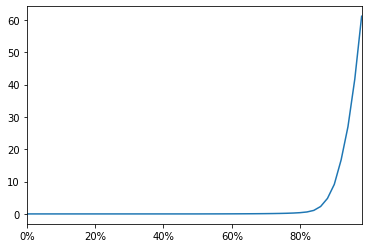

In [91]:
s_delta.plot("line")

In [95]:
# cut gap
df_train_click["t_diff_10_6"] = df_train_click["t_diff"] * 10 ** 6 

In [101]:
df_train_click.query("user_id == '1'")

,user_id,item_id,time,Phase,t_diff,t_diff_10_6
0,1,78142,0.983742,0,NaN,NaN
1,1,26646,0.983757,0,1.503658e-05,15.036582
2,1,89568,0.983763,0,6.781414e-06,6.781414
3,1,76240,0.983770,0,6.995285e-06,6.995285
4,1,87533,0.983790,0,1.907426e-05,19.074265
...,...,...,...,...,...,...
98,1,38715,0.984270,6,3.972953e-05,39.729534
99,1,108734,0.984270,6,1.268085e-07,0.126808
100,1,13085,0.984270,6,6.119613e-08,0.061196
101,1,15072,0.984270,6,8.832431e-09,0.008832


In [102]:
GAP = 4.793840

In [111]:
df_train_click["Keep_label"] = df_train_click["t_diff_10_6"] < GAP

In [113]:
df_train_click["Keep_label"].sum() / df_train_click.shape[0]

0.8652833052449133

# drop dup

In [118]:
df_train_click.drop_duplicates(["user_id", "item_id", "time"]).groupby("Phase").count()["user_id"]

Phase
0    241784
1    109491
2    105755
3    121135
4    108695
5    117183
6    130822
Name: user_id, dtype: int64

In [117]:
df_train_click.groupby("Phase").count()["user_id"]

Phase
0    241784
1    242132
2    243569
3    264263
4    266994
5    287523
6    310372
Name: user_id, dtype: int64

In [116]:
df_train_click.head(20)

,user_id,item_id,time,Phase,t_diff,t_diff_10_6,Keep_label
0,1,78142,0.983742,0,NaN,NaN,False
1,1,26646,0.983757,0,1.503658e-05,15.036582,False
2,1,89568,0.983763,0,6.781414e-06,6.781414,False
3,1,76240,0.983770,0,6.995285e-06,6.995285,False
4,1,87533,0.983790,0,1.907426e-05,19.074265,False
5,1,78380,0.983790,0,2.081930e-08,0.020819,True
6,1,85492,0.983875,0,8.595343e-05,85.953429,False
7,1,85492,0.983875,2,0.000000e+00,0.000000,True
8,1,97795,0.983877,0,1.643463e-06,1.643463,True
9,1,18522,0.983887,0,9.419787e-06,9.419787,False


In [ ]:
df_data_mapping[""]